In [1]:
from utils import *

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np

import gym
import matplotlib.pyplot as plt

In [2]:
NUM_RUNS = 10
EPSILON = 1      # placeholder value - you should implement your own exploration schedule

## Unoptimised Agent

In [4]:
parameters_unoptimised = {
    "learning_rate_start": 1e-2,
    "structure_DQN_policy": [4, 2],
    "structure_DQN_target": [4, 2],
    "size_buffer": 10000, 
    "size_batch": 256,
    "epsilon": 1,
    "nb_episode": 200,
    "freq_update_target": 1,
    "steep_eps_decay": 25,
    "step_size_lr": 25,
    "gamma_lr": 0.5,
    "w_dcy": 1e-4
}

## Optimised Agent

In [5]:
parameters_optimised = {
    "learning_rate_start": 1e-2,
    "structure_DQN_policy": [4, 64, 64, 2],
    "structure_DQN_target": [4, 64, 64, 2],
    "size_buffer": 10000,
    "size_batch": 256,
    "epsilon": 1,
    "nb_episode": 225,
    "freq_update_target": 1,
    "steep_eps_decay": 25,
    "step_size_lr": 25,
    "gamma_lr": 0.5,
    "w_dcy": 1e-4
}

## Test Agent for hyperparameter search

In [6]:
parameters_test = {
    "learning_rate_start": 1e-2,
    "structure_DQN_policy": [4, 64, 64, 2],
    "structure_DQN_target": [4, 64, 64, 2],
    "size_buffer": 10000,
    "size_batch": 256,
    "epsilon": 1,
    "nb_episode": 225,
    "freq_update_target": 1,
    "steep_eps_decay": 25,
    "step_size_lr": 25,
    "gamma_lr": 0.5,
    "w_dcy": 1e-4
}

## Run experiments

#### Run experiment Function

In [7]:
def run_experiments(parameters, nums_run):
    """
    Conduct a series of experiments using Deep Q-Networks (DQN) on the CartPole environment from OpenAI's gym.

    This function initializes a CartPole environment and performs a specified number of experimental runs. 
    Each run involves training a policy network and a target network based on the provided parameters. 
    The training process includes steps like action selection using epsilon-greedy strategy, experience replay, and periodic updating of the target network.

    Parameters:
    parameters (dict): A dictionary containing key-value pairs for various hyperparameters.
    nums_run (int): Number of experimental runs to perform.

    Returns:
    tuple: A tuple containing two elements:
        - A list of lists where each inner list contains the duration of each episode for a particular run.
        - The trained policy network after the final experimental run.
    """

    runs_results = []   #list containing the final result

    env = gym.make('CartPole-v1')   #creation of the cart pole environment 
    for run in range(nums_run):
        print(f"Starting run {run+1} of {nums_run}")
        policy_net = DQN(parameters["structure_DQN_policy"])  #initialisation of policy network
        target_net = DQN(parameters["structure_DQN_target"])  #initialisation of target network
        update_target(target_net, policy_net)
        target_net.eval()

        optimizer = optim.AdamW(policy_net.parameters(), lr=parameters["learning_rate_start"], weight_decay=parameters["w_dcy"], amsgrad=True)  #optimiser definition for a run

        memory = ReplayBuffer(parameters["size_buffer"])  # Initialisation of the storage

        steps_done = 0

        episode_durations = []

        for i_episode in range(parameters["nb_episode"]): # episode starting and then creation of a trace
            if (i_episode+1) % 50 == 0:
                print("episode ", i_episode+1, "/", parameters["nb_episode"])

            # Every 25 episodes the learning rate is decay by gamma_lr, except for episode index 0
            if i_episode % parameters["step_size_lr"] == 0 and i_episode > 0:
                for g in optimizer.param_groups:
                    g['lr'] *= parameters["gamma_lr"]

            observation, info = env.reset()
            state = torch.tensor(observation).float()

            done = False
            terminated = False
            t = 0

            EPSILON = eps_decay(i_episode, parameters["steep_eps_decay"])  # Update of the epsilon according to exponential decay

            while not (done or terminated):

                # Select and perform an action
                action = epsilon_greedy(EPSILON, policy_net, state) # epsilon-greedy choice

                observation, reward, done, terminated, info = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < parameters["size_batch"]:
                    transitions = memory.sample(parameters["size_batch"])
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse_loss.backward()
                    optimizer.step()
                
                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1

            # Update the target network, copying all weights and biases in DQN, at the end of each episode
            if i_episode % parameters["freq_update_target"] == 0:   # frequency of update
                update_target(target_net, policy_net)
        runs_results.append(episode_durations)
    print('Complete')
    return runs_results, policy_net

In [8]:
def run_and_plot_experiments(num_iterations, parameters, nums_run):
    """
    Executes a series of experiments using DQNs on the CartPole environment and plots the results.

    This function runs a set of experiments over a specified number of iterations. 
    In each iteration, it conducts multiple runs of DQN experiments on the CartPole environment using the `run_experiments` function. 
    After each iteration, the results of the tests are plotted. The function accumulates and returns the results of all iterations along with the policy networks obtained in each iteration.

    Parameters:
    num_iterations (int): The number of iterations for the entire experiment. Each iteration includes multiple runs as specified by `nums_run`.
    parameters (dict): A dictionary of parameters to be passed to the `run_experiments` function (containing hyperparameter configuration).
    nums_run (int): The number of experimental runs to perform in each iteration of the experiment.

    Returns:
    tuple: A tuple containing two elements:
        - A list of lists of lists, where each innermost list contains the duration of each episode for a particular run in an iteration.
        - A list of lists containing the policy networks obtained for each run in every iteration.

    Note:
    - The `plot_results` function is used to visualize the results of each experiment iteration.
    """
    all_runs_results = []
    all_policy_result = []
    
    for i in range(num_iterations): # loop for repeating the experimentation, each containing nums_run training runs
        print(f"Experiment Iteration: {i+1}/{num_iterations}")
        test_results, policy_results = run_experiments(parameters, nums_run)
        all_runs_results.append(test_results)
        all_policy_result.append(policy_results)
        plot_results(test_results, parameters)  # plot the learning curve of a given experimentation containing nums_run training runs
        
    return all_runs_results, all_policy_result

#### Test and plots

In [9]:
test_all, test_target_policy = run_experiments(parameters_test, NUM_RUNS)

Starting run 1 of 10


/Users/julesviard/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 2 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 3 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 4 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 5 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 6 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 7 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 8 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 9 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 10 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Complete


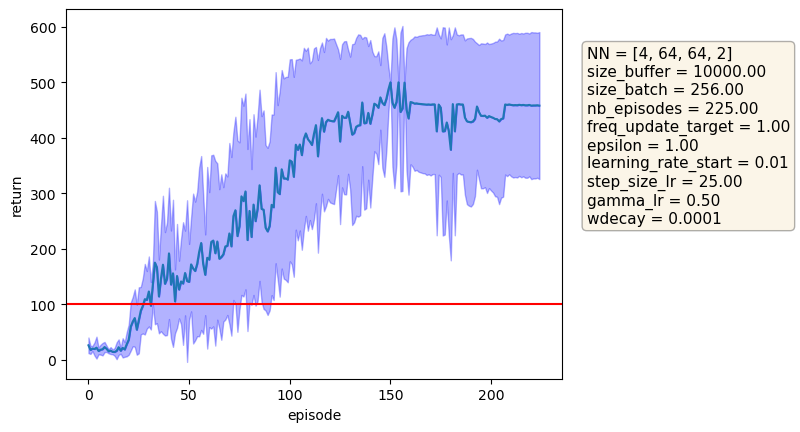

In [10]:
plot_results(test_all, parameters_test)

## Buffer and batch size

In [109]:
parameters_buffer10000_b1 = {
    "learning_rate_start": 1e-2,
    "structure_DQN_policy": [4, 64, 64, 2],
    "structure_DQN_target": [4, 64, 64, 2],
    "size_buffer": 10000,
    "size_batch": 128,
    "nb_episode": 225,
    "freq_update_target": 1,
    "steep_eps_decay": 25,
    "step_size_lr": 25,
    "gamma_lr": 0.5,
    "w_dcy": 1e-4
}
parameters_buffer10000_b2 = {
    "learning_rate_start": 1e-2,
    "structure_DQN_policy": [4, 64, 64, 2],
    "structure_DQN_target": [4, 64, 64, 2],
    "size_buffer": 10000,
    "size_batch": 256,
    "nb_episode": 225,
    "freq_update_target": 1,
    "steep_eps_decay": 25,
    "step_size_lr": 25,
    "gamma_lr": 0.5,
    "w_dcy": 1e-4
}
parameters_buffer10000_b3 = {
    "learning_rate_start": 1e-2,
    "structure_DQN_policy": [4, 64, 64, 2],
    "structure_DQN_target": [4, 64, 64, 2],
    "size_buffer": 10000,
    "size_batch": 512,
    "nb_episode": 225,
    "freq_update_target": 1,
    "steep_eps_decay": 25,
    "step_size_lr": 25,
    "gamma_lr": 0.5,
    "w_dcy": 1e-4
}

In [110]:
parameters_buffer2500_b1 = {
    "learning_rate_start": 1e-2,
    "structure_DQN_policy": [4, 64, 64, 2],
    "structure_DQN_target": [4, 64, 64, 2],
    "size_buffer": 2500,
    "size_batch": 128,
    "nb_episode": 225,
    "freq_update_target": 1,
    "steep_eps_decay": 25,
    "step_size_lr": 25,
    "gamma_lr": 0.5,
    "w_dcy": 1e-4
}
parameters_buffer2500_b2 = {
    "learning_rate_start": 1e-2,
    "structure_DQN_policy": [4, 64, 64, 2],
    "structure_DQN_target": [4, 64, 64, 2],
    "size_buffer": 2500,
    "size_batch": 256,
    "nb_episode": 225,
    "freq_update_target": 1,
    "steep_eps_decay": 25,
    "step_size_lr": 25,
    "gamma_lr": 0.5,
    "w_dcy": 1e-4
}
parameters_buffer2500_b3 = {
    "learning_rate_start": 1e-2,
    "structure_DQN_policy": [4, 64, 64, 2],
    "structure_DQN_target": [4, 64, 64, 2],
    "size_buffer": 2500,
    "size_batch": 512,
    "nb_episode": 225,
    "freq_update_target": 1,
    "steep_eps_decay": 25,
    "step_size_lr": 25,
    "gamma_lr": 0.5,
    "w_dcy": 1e-4
}

In [144]:
run1_batch10000, policy_net1_batch10000 = run_experiments(parameters_buffer10000_b1, NUM_RUNS)
run2_batch10000, policy_net2_batch10000 = run_experiments(parameters_buffer10000_b2, NUM_RUNS)
run3_batch10000, policy_net3_batch10000 = run_experiments(parameters_buffer10000_b3, NUM_RUNS)

Starting run 1 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 2 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 3 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 4 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 5 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 6 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 7 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 8 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 9 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 10 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Complete
Starting run 1 of 10
episode  

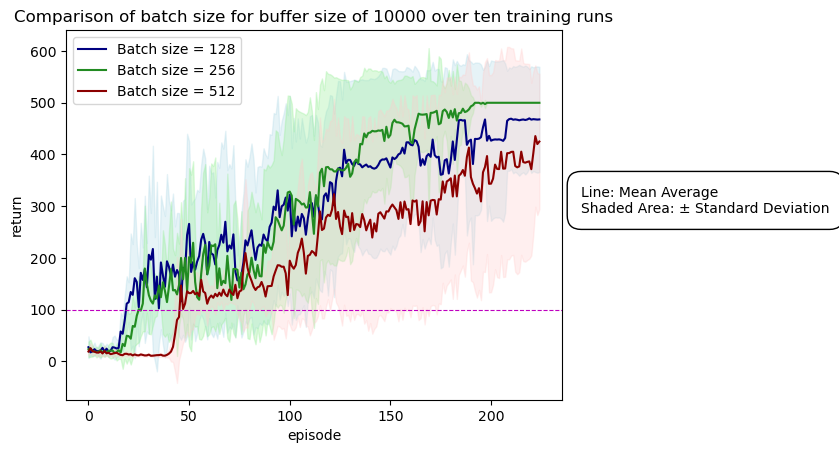

In [464]:
plot_comparison_buffer_batch(run1_batch10000, parameters_buffer10000_b1, run2_batch10000, parameters_buffer10000_b2, run3_batch10000, parameters_buffer10000_b3)

In [112]:
run1_batch2500, policy_net1_batch2500 = run_experiments(parameters_buffer2500_b1, NUM_RUNS)
run2_batch2500, policy_net2_batch2500 = run_experiments(parameters_buffer2500_b2, NUM_RUNS)
run3_batch2500, policy_net3_batch2500 = run_experiments(parameters_buffer2500_b3, NUM_RUNS)

Starting run 1 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 2 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 3 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 4 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 5 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 6 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 7 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 8 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 9 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 10 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Complete
Starting run 1 of 10
episode  

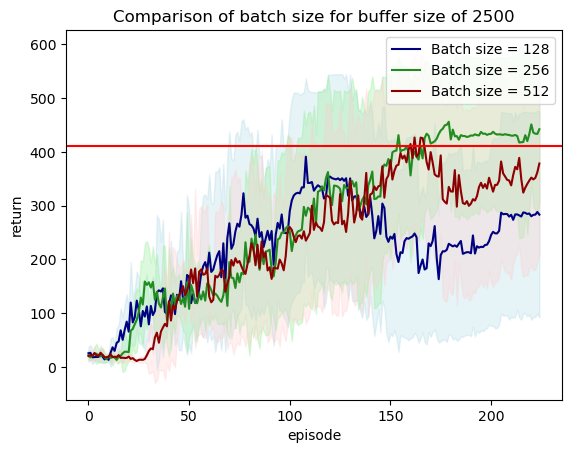

In [139]:
plot_comparison_buffer_batch(run1_batch2500, parameters_buffer2500_b1, run2_batch2500, parameters_buffer2500_b2, run3_batch2500, parameters_buffer2500_b3)

## Epsilon decay comparison

In [94]:
parameters_eps1 = {
    "learning_rate_start": 1e-2,
    "structure_DQN_policy": [4, 64, 64, 2],
    "structure_DQN_target": [4, 64, 64, 2],
    "size_buffer": 10000,
    "size_batch": 256,
    "nb_episode": 225,
    "freq_update_target": 1,
    "steep_eps_decay": 10,
    "step_size_lr": 25,
    "gamma_lr": 0.5,
    "w_dcy": 1e-4
}
parameters_eps2 = {
    "learning_rate_start": 1e-2,
    "structure_DQN_policy": [4, 64, 64, 2],
    "structure_DQN_target": [4, 64, 64, 2],
    "size_buffer": 10000,
    "size_batch": 256,
    "nb_episode": 225,
    "freq_update_target": 1,
    "steep_eps_decay": 25,
    "step_size_lr": 25,
    "gamma_lr": 0.5,
    "w_dcy": 1e-4
}
parameters_eps3 = {
    "learning_rate_start": 1e-2,
    "structure_DQN_policy": [4, 64, 64, 2],
    "structure_DQN_target": [4, 64, 64, 2],
    "size_buffer": 10000,
    "size_batch": 256,
    "nb_episode": 225,
    "freq_update_target": 1,
    "steep_eps_decay": 45,
    "step_size_lr": 25,
    "gamma_lr": 0.5,
    "w_dcy": 1e-4
}

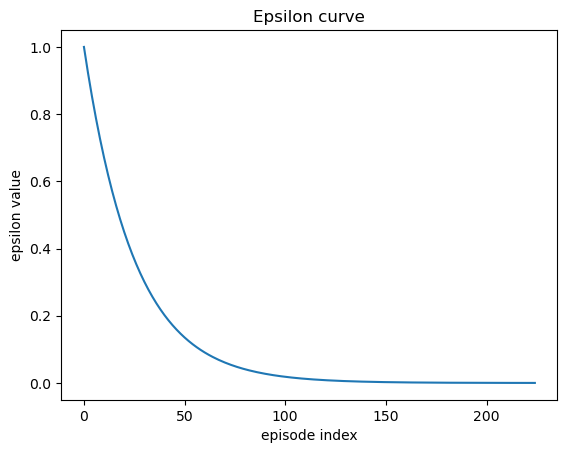

In [11]:
plot_eps_decay(25, 225)

In [107]:
run1_eps, policy_net1_eps = run_experiments(parameters_eps1, NUM_RUNS)
run2_eps, policy_net2_eps = run_experiments(parameters_eps2, NUM_RUNS)
run3_eps, policy_net3_eps = run_experiments(parameters_eps3, NUM_RUNS)

Starting run 1 of 10


/Users/julesviard/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 2 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 3 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 4 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 5 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 6 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 7 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 8 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 9 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 10 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Complete
Starting run 1 of 10
episode  50 / 225
episode  100

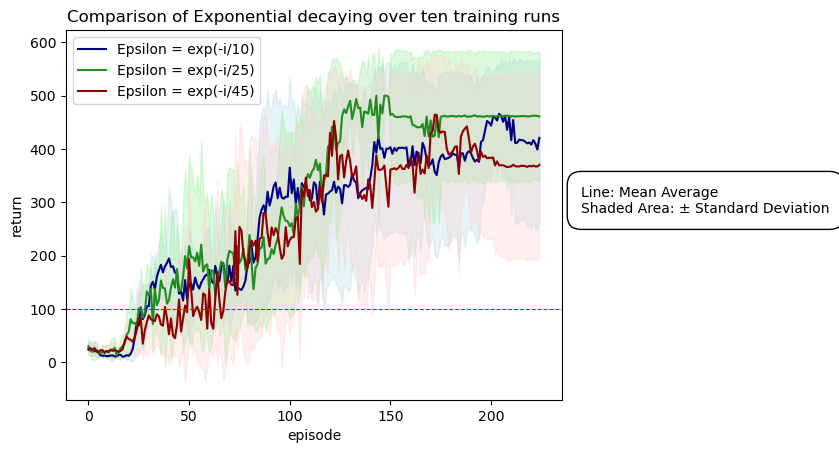

In [468]:
plot_comparison_eps(run1_eps, parameters_eps1, run2_eps, parameters_eps2, run3_eps, parameters_eps3)

## Learning rate comparison

In [155]:
parameters_lr1 = {
    "learning_rate_start": 1,
    "structure_DQN_policy": [4, 64, 64, 2],
    "structure_DQN_target": [4, 64, 64, 2],
    "size_buffer": 10000,
    "size_batch": 256,
    "nb_episode": 225,
    "freq_update_target": 1,
    "steep_eps_decay": 25,
    "step_size_lr": 25,
    "gamma_lr": 0.5,
    "w_dcy": 1e-4
}
parameters_lr2 = {
    "learning_rate_start": 1e-2,
    "structure_DQN_policy": [4, 64, 64, 2],
    "structure_DQN_target": [4, 64, 64, 2],
    "size_buffer": 10000,
    "size_batch": 256,
    "nb_episode": 225,
    "freq_update_target": 1,
    "steep_eps_decay": 25,
    "step_size_lr": 25,
    "gamma_lr": 0.5,
    "w_dcy": 1e-4
}
parameters_lr3 = {
    "learning_rate_start": 1e-4,
    "structure_DQN_policy": [4, 64, 64, 2],
    "structure_DQN_target": [4, 64, 64, 2],
    "size_buffer": 10000,
    "size_batch": 256,
    "nb_episode": 225,
    "freq_update_target": 1,
    "steep_eps_decay": 25,
    "step_size_lr": 25,
    "gamma_lr": 0.5,
    "w_dcy": 1e-4
}

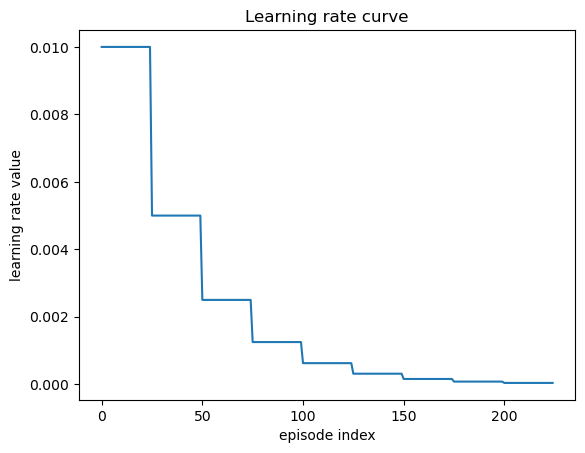

In [429]:
plot_learning_evolution(parameters_optimised)

In [156]:
run1_lr, policy_net1_lr = run_experiments(parameters_lr1, NUM_RUNS)
run2_lr, policy_net2_lr = run_experiments(parameters_lr2, NUM_RUNS)
run3_lr, policy_net3_lr = run_experiments(parameters_lr3, NUM_RUNS)

Starting run 1 of 10


/Users/julesviard/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 2 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 3 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 4 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 5 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 6 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 7 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 8 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 9 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 10 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Complete
Starting run 1 of 10
episode  50 / 225
episode  100

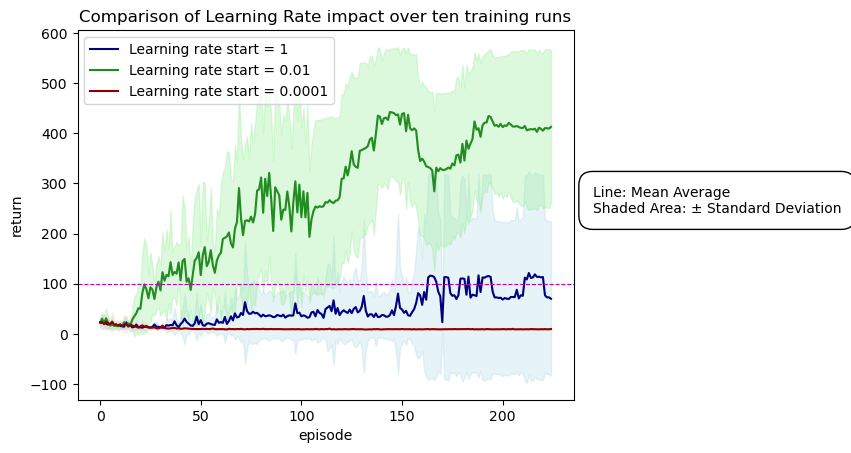

In [477]:
plot_comparison_lr(run1_lr, parameters_lr1, run2_lr, parameters_lr2, run3_lr, parameters_lr3)

## Halving of weight_decay

In [166]:
parameters_weightdecay1 = {
    "learning_rate_start": 1e-2,
    "structure_DQN_policy": [4, 64, 64, 2],
    "structure_DQN_target": [4, 64, 64, 2],
    "size_buffer": 10000,
    "size_batch": 256,
    "nb_episode": 225,
    "freq_update_target": 1,
    "steep_eps_decay": 25,
    "step_size_lr": 25,
    "gamma_lr": 0.5,
    "w_dcy": 1e-1
}
parameters_weightdecay2 = {
    "learning_rate_start": 1e-2,
    "structure_DQN_policy": [4, 64, 64, 2],
    "structure_DQN_target": [4, 64, 64, 2],
    "size_buffer": 10000,
    "size_batch": 256,
    "nb_episode": 225,
    "freq_update_target": 1,
    "steep_eps_decay": 25,
    "step_size_lr": 25,
    "gamma_lr": 0.5,
    "w_dcy": 1e-4
}
parameters_weightdecay3 = {
    "learning_rate_start": 1e-2,
    "structure_DQN_policy": [4, 64, 64, 2],
    "structure_DQN_target": [4, 64, 64, 2],
    "size_buffer": 10000,
    "size_batch": 256,
    "nb_episode": 225,
    "freq_update_target": 1,
    "steep_eps_decay": 25,
    "step_size_lr": 25,
    "gamma_lr": 0.5,
    "w_dcy": 1e-7
}

In [167]:
def run_experiment_weightdecay_halving(parameters, nums_run):
    """
    Conducts a series of runs with an evolving weight decay parameter.

    Parameters:
    parameters (dict): A dictionary of hyperparameters.
    nums_run (int): Number of experimental runs to be conducted.

    Returns:
    tuple: A tuple containing:
        - A list of every runs information.
        - The final state of the policy network after the last run.
    """
    runs_results = []

    env = gym.make('CartPole-v1')
    for run in range(nums_run):
        print(f"Starting run {run+1} of {nums_run}")
        policy_net = DQN(parameters["structure_DQN_policy"])
        target_net = DQN(parameters["structure_DQN_target"])
        update_target(target_net, policy_net)
        target_net.eval()

        optimizer = optim.AdamW(policy_net.parameters(), lr=parameters["learning_rate_start"], weight_decay=parameters["w_dcy"], amsgrad=True)

        memory = ReplayBuffer(parameters["size_buffer"])

        steps_done = 0

        episode_durations = []

        weight_decay_evolve = parameters["w_dcy"]

        for i_episode in range(parameters["nb_episode"]):
            if (i_episode+1) % 50 == 0:
                print("episode ", i_episode+1, "/", parameters["nb_episode"])

            # Update weight_decay every 60 episodes
            if i_episode > 0 and i_episode % 60 == 0:
                weight_decay_evolve *= 10
                for g in optimizer.param_groups:
                    g['weight_decay'] = weight_decay_evolve

            if i_episode % parameters["step_size_lr"] == 0 and i_episode > 0:
                for g in optimizer.param_groups:
                    g['lr'] *= parameters["gamma_lr"]

            observation, info = env.reset()
            state = torch.tensor(observation).float()

            done = False
            terminated = False
            t = 0

            EPSILON = eps_decay(i_episode, parameters["steep_eps_decay"])

            while not (done or terminated):

                # Select and perform an action
                action = epsilon_greedy(EPSILON, policy_net, state)

                observation, reward, done, terminated, info = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < parameters["size_batch"]:
                    transitions = memory.sample(parameters["size_batch"])
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse_loss.backward()
                    optimizer.step()
                
                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1

            # Update the target network, copying all weights and biases in DQN
            if i_episode % parameters["freq_update_target"] == 0:
                update_target(target_net, policy_net)
        runs_results.append(episode_durations)
    print('Complete')
    return runs_results, policy_net

In [172]:
run1_weightdecay, policy_net1_weightdecay = run_experiments(parameters_weightdecay1, NUM_RUNS)
run2_weightdecay, policy_net2_weightdecay = run_experiments(parameters_weightdecay2, NUM_RUNS)
run3_weightdecay, policy_net3_weightdecay = run_experiments(parameters_weightdecay3, NUM_RUNS)

Starting run 1 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 2 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 3 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 4 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 5 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 6 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 7 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 8 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 9 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 10 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Complete
Starting run 1 of 10
episode  

In [170]:
run1_weightdecay_adapt, policy_net1_weightdecay_adapt = run_experiment_weightdecay_halving(parameters_weightdecay2, NUM_RUNS)

Starting run 1 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 2 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 3 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 4 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 5 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 6 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 7 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 8 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 9 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 10 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Complete


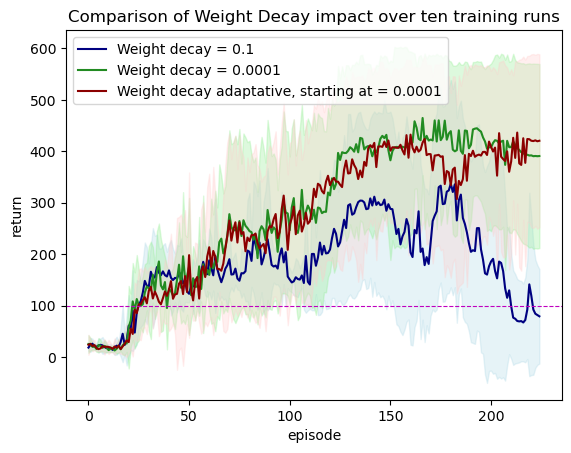

In [208]:
plot_comparison_weightdecay(run1_weightdecay, parameters_weightdecay1, run2_weightdecay, parameters_weightdecay2, run1_weightdecay_adapt, parameters_weightdecay2)

## Learning Curve

In [194]:
run_agent_optimsed, policy_net_agent_optimised = run_experiments(parameters_optimised, NUM_RUNS)

Starting run 1 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 2 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 3 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 4 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 5 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 6 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 7 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 8 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 9 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Starting run 10 of 10
episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Complete


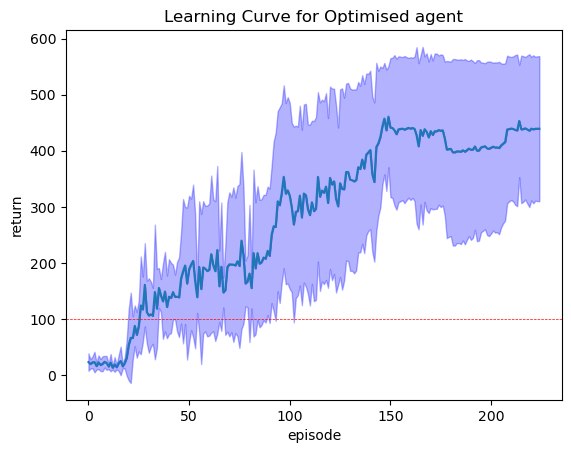

In [398]:
plot_result_learning_curve(run_agent_optimsed, parameters_optimised)

## Visualisation of the DQN policy

### Run experiment function for a unique agent

In [13]:
def run_experiments_unique(parameters):
    """
    Conducts a unique traning run for a given configuration of hyperparameter.
    This function can be used to generate a single experiment in order to conduct slice investigation.

    Parameters:
    parameters (dict): A dictionary of hyperparameters.

    Returns:
    tuple: A tuple containing:
        - A list containing run information (reward result).
        - The final state of the policy network after the last run.
    """
    runs_results = []

    env = gym.make('CartPole-v1')
    for run in range(1):
        print(f"Starting run {run+1} of {1}")
        policy_net = DQN(parameters["structure_DQN_policy"])
        target_net = DQN(parameters["structure_DQN_target"])
        update_target(target_net, policy_net)
        target_net.eval()

        optimizer = optim.AdamW(policy_net.parameters(), lr=parameters["learning_rate_start"], weight_decay=parameters["w_dcy"], amsgrad=True)


        memory = ReplayBuffer(parameters["size_buffer"])

        steps_done = 0

        episode_durations = []

        for i_episode in range(parameters["nb_episode"]):
            if (i_episode+1) % 50 == 0:
                print("episode ", i_episode+1, "/", parameters["nb_episode"])


            if i_episode % parameters["step_size_lr"] == 0 and i_episode > 0:
                for g in optimizer.param_groups:
                    g['lr'] *= parameters["gamma_lr"]

            observation, info = env.reset()
            state = torch.tensor(observation).float()

            done = False
            terminated = False
            t = 0

            EPSILON = eps_decay(i_episode, parameters["steep_eps_decay"])

            while not (done or terminated):

                # Select and perform an action
                action = epsilon_greedy(EPSILON, policy_net, state)

                observation, reward, done, terminated, info = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < parameters["size_batch"]:
                    transitions = memory.sample(parameters["size_batch"])
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse_loss.backward()
                    optimizer.step()
                
                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1

            # Update the target network, copying all weights and biases in DQN
            if i_episode % parameters["freq_update_target"] == 0:
                update_target(target_net, policy_net)
        runs_results.append(episode_durations)
    print('Complete')
    return runs_results, policy_net

In [14]:
run_agent_unique_DQN, policy_net_unique_DQN = run_experiments_unique(parameters_optimised)

Starting run 1 of 1


/Users/julesviard/anaconda3/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode  50 / 225
episode  100 / 225
episode  150 / 225
episode  200 / 225
Complete


### Cell for Slices of the greedy policy action

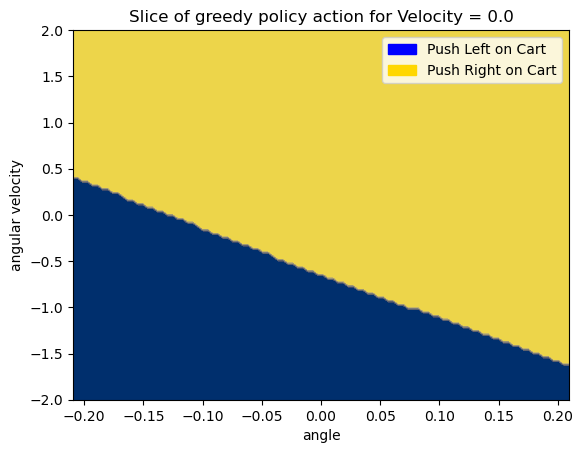

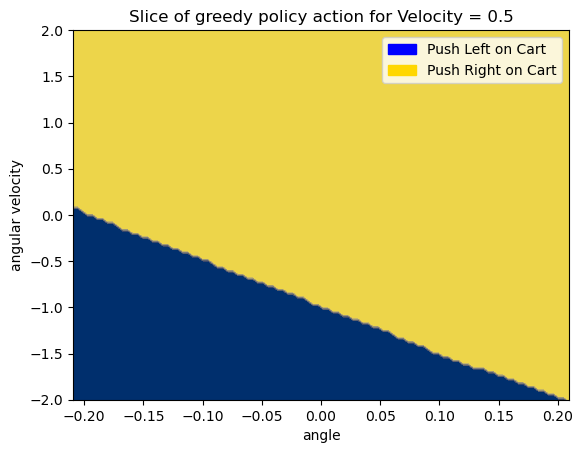

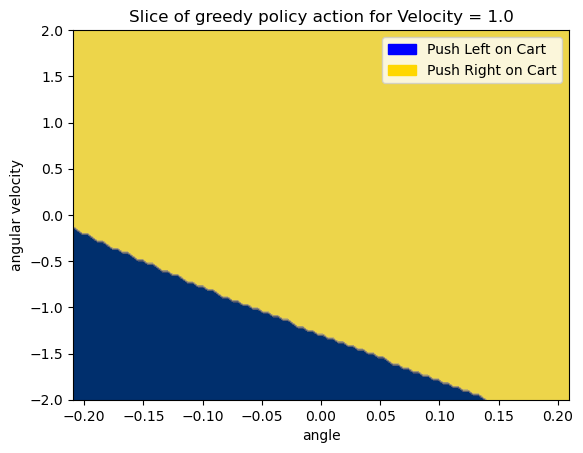

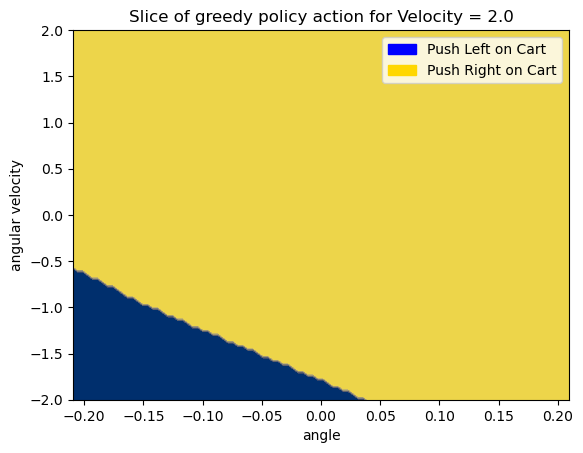

In [419]:
# Cell for Slices of the greedy policy action

policy_net = policy_net_unique_DQN
q = False    # whether q values or greedy policy is visualised

angle_range = .2095
omega_range = 2

velocities = [0., 0.5, 1., 2.]

angle_samples = 100
omega_samples = 100

angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)


for idx_plot, vel in enumerate(velocities):

    greedy_q_array = torch.zeros((angle_samples, omega_samples))
    policy_array = torch.zeros((angle_samples, omega_samples))

    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            state = torch.tensor([0, vel, angle, omega])
            with torch.no_grad():
                q_vals = policy_net(state)
                greedy_action = q_vals.argmax()
                greedy_q_array[i, j] = q_vals[greedy_action]
                policy_array[i, j] = greedy_action
    if q:
        plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
    else:
        plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
    left_legend = plt.Rectangle((0, 0), 1, 1, color='blue')
    right_legend = plt.Rectangle((0, 0), 1, 1, color='#FFD700')
    plt.legend([left_legend, right_legend], ["Push Left on Cart", "Push Right on Cart"], loc = "upper right")
    plt.xlabel("angle")
    plt.ylabel("angular velocity")
    plt.title(f"Slice of greedy policy action for Velocity = {vel}")
    plt.show() 

### Cell for slices of the Q-function

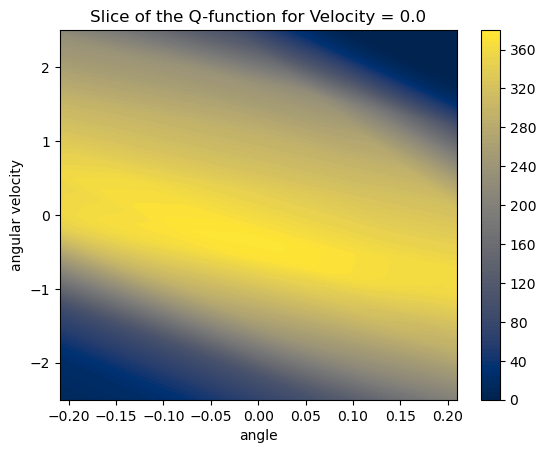

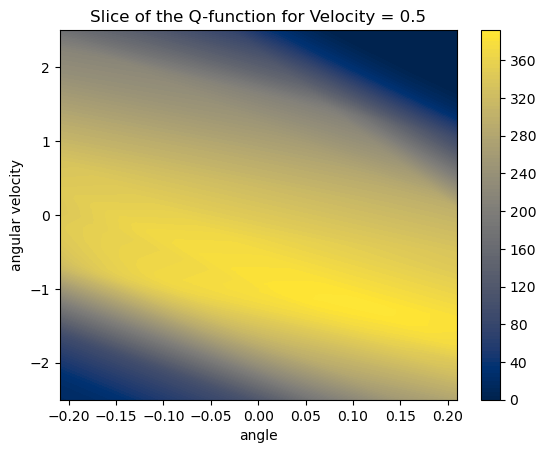

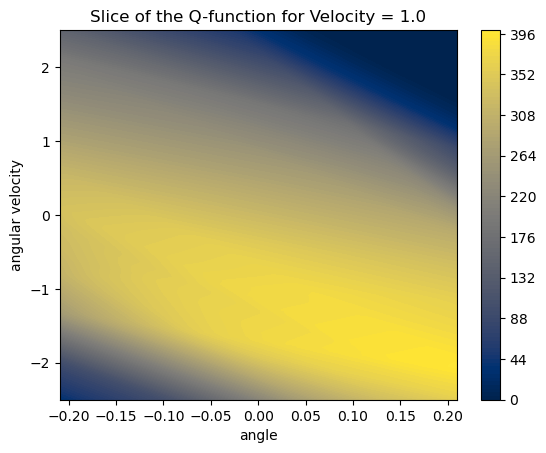

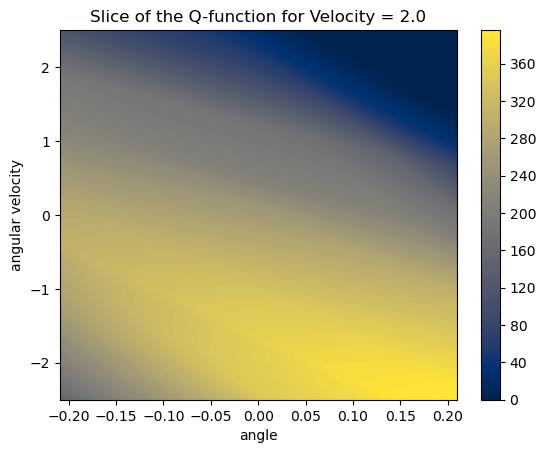

In [292]:
policy_net =  policy_net_unique_DQN
q = True    # whether q values or greedy policy is visualised

angle_range = .2095 # you may modify this range
omega_range = 2.5     # you may modify this range

velocities = [0., 0.5, 1., 2.]

angle_samples = 100
omega_samples = 100

angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)


for vel in velocities:

    greedy_q_array = torch.zeros((angle_samples, omega_samples))
    policy_array = torch.zeros((angle_samples, omega_samples))

    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            state = torch.tensor([0, vel, angle, omega])
            with torch.no_grad():
                q_vals = policy_net(state)
                greedy_action = q_vals.argmax()
                greedy_q_array[i, j] = q_vals[greedy_action]
                policy_array[i, j] = greedy_action
    if q:
        plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
    else:
        plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
    plt.xlabel("angle")
    plt.ylabel("angular velocity")
    plt.title(f"Slice of the Q-function for Velocity = {vel}")
    plt.colorbar()
    plt.show()